# Time Series and Volatility

In this notebook we look at returns as a time series and build basic
understanding of volatility. Goals:

1. Compute daily returns for S&P500
2. Plot prices and returns over time  
3. Compute rolling volatility 
4. Compute EWMA volatility 
5. Compute GARCH volatility 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

plt.style.use("default")

# Ticker and date range
ticker = "^GSPC"   # S&P 500 index
start_date = "2015-01-01"
end_date = None  # up to today

data = yf.download(ticker, start=start_date, end=end_date)
prices = data["Close"].dropna()

print(prices.head())
print("\nNumber of observations:", len(prices))


/var/folders/yd/9m_x6xcd71jc27zn8nj9jjxw0000gn/T/ipykernel_26718/1057102218.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Ticker            ^GSPC
Date                   
2015-01-02  2058.199951
2015-01-05  2020.579956
2015-01-06  2002.609985
2015-01-07  2025.900024
2015-01-08  2062.139893

Number of observations: 2742


### 1. From prices to returns
Returns measure the gain or loss on an investment over a given period, relative to the amount invested at the start of that period.
In this notebook, we work with with daily simple returns:

$$
R_t = \frac{P_t}{P_{t-1}} - 1
$$

Here:

- $P_{t-1}$ is yesterday’s price  
- $P_t$ is today’s price  
- $R_t$ is the percentage change from yesterday to today

Returns are a time series: each day depends on what came before.

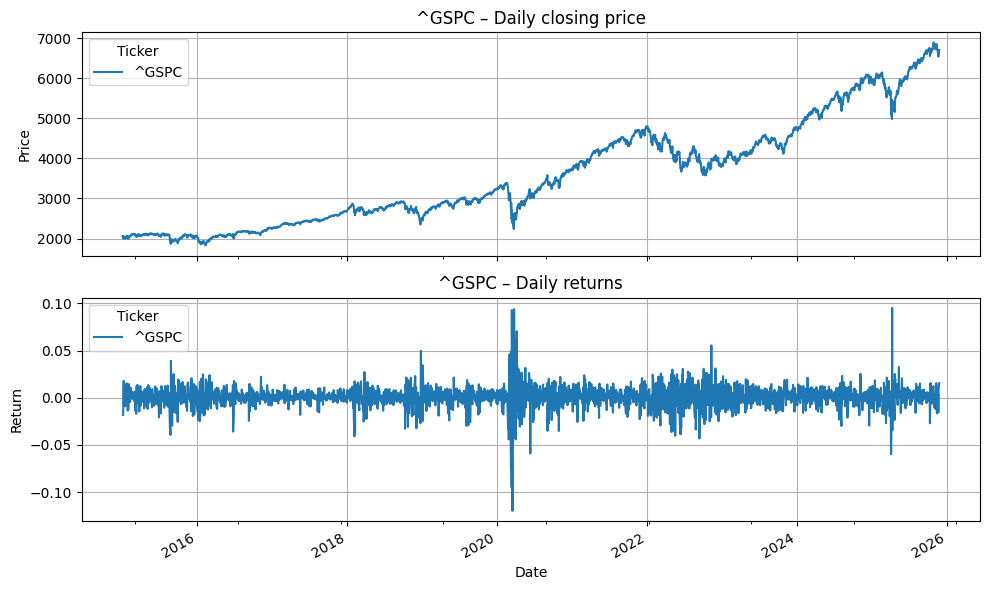

In [2]:
# Daily simple returns
returns = prices.pct_change().dropna()

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

prices.plot(ax=ax[0])
ax[0].set_title(f"{ticker} – Daily closing price")
ax[0].set_ylabel("Price")
ax[0].grid(True)

returns.plot(ax=ax[1])
ax[1].set_title(f"{ticker} – Daily returns")
ax[1].set_ylabel("Return")
ax[1].grid(True)

plt.tight_layout()
plt.show()


### 2. Volatility

Volatility is usually measured as the standard deviation of returns. A single volatility number for the whole sample,while meaningful statistically, hides when markets were calm and when they were turbulent. To see how volatility evolves over time, we compute a rolling standard deviation of returns.

The idea is:

- Pick a window length, for example 21 trading days (about one month).
- For each day $ t $, look back at the last 21 daily returns:
  $$
  R_{t-20}, R_{t-19}, \dots, R_t
  $$
- Compute the standard deviation of these 21 returns.  
  This gives the volatility estimate at day $ t $:
  $$
  \sigma_{t}^{(21)} = \text{std}\{ R_{t-20}, \dots, R_t \}
  $$
- Move one day forward and repeat, so the window “rolls” along the time axis.


In practice, we estimate daily(or monthly) volatility from recent returns, then scale it to a yearly number to obtain the annualised volatility since this is the standard convention.

- For monthly data, annualised volatility is:
  $$
  \sigma_{\text{annual}} = \sigma_{\text{month}} \sqrt{12}
  $$

- For daily data (with 252 trading days a year) : 
  $$
  \sigma_{\text{annual}} = \sigma_{\text{daily}} \sqrt{252}
  $$
In other words, the question is "How does the current annualised volatility estimate, based on the last month of returns, move over time?"

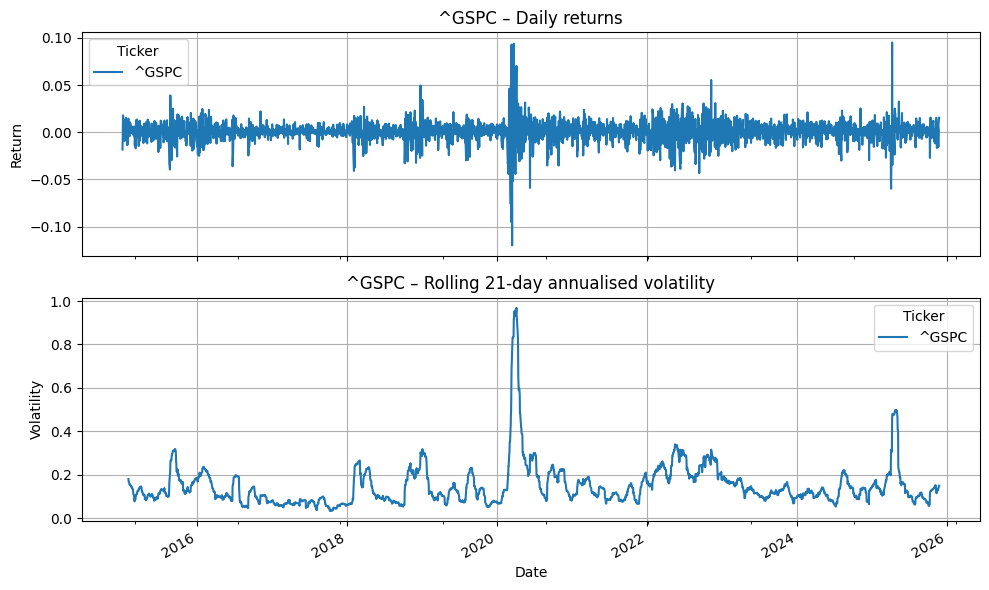

In [ ]:
window = 21  # 21 trading days 
daily_vol_21 = returns.rolling(window).std()
ann_vol_21 = daily_vol_21 * np.sqrt(252)  # annualised

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

returns.plot(ax=ax[0])
ax[0].set_title(f"{ticker} – Daily returns")
ax[0].set_ylabel("Return")
ax[0].grid(True)

ann_vol_21.plot(ax=ax[1])
ax[1].set_title(f"{ticker} – Rolling {window}-day annualised volatility")
ax[1].set_ylabel("Annualised Volatility")
ax[1].grid(True)

plt.tight_layout()
plt.show()


  We see here that the volatility clearly evolves over time, and understanbly market risk is far from being constant. There are long periods where things are calm and stable, but we also see episodes where it spikes sharply, for example around the COVID crash in 2020. Once volatility jumps, it tends to remain elevated for some time rather than dropping back immediately, which is the classic clustering behaviour we expect in financial returns.

But this approch relies on an arbitrary window length and treats all observations inside the window equally, even though very recent returns are usually more informative about current risk. Hence we explore alternatives to address this.

### 3. EWMA volatility

The Exponentially Weighted Moving Average (EWMA), or simply EWMA volatiliy, gives more weight to
recent returns and less weight to older ones. We do this by defining a decay factor $ \lambda $, which controls how quickly the past is discounted.

For daily returns $ R_t $ the EWMA variance is defined as:

$$
\sigma_t^2 = \lambda \,\sigma_{t-1}^2 + (1 - \lambda)\,R_t^2
$$

Here:

- $ \sigma_{t-1}^2 $ is yesterday’s variance estimate (the “old view” of risk),
- $ R_t^2 $ is today’s squared return (the new information),
- $ \lambda \in (0, 1) $ decides how much weight we keep on the old view.

If $ \lambda $ is close to 1, we give a lot of weight to the past and only a little weight to today’s return. Volatility then moves smoothly and
remembers shocks for a long time.  If $ \lambda $ is smaller, we downweight history faster and volatility reacts more aggressively to new shocks.

In practice, a common choice for daily financial data is $ \lambda \approx 0.94 $ (used in the RiskMetrics framework), which gives a reasonable balance between stability and responsiveness. Once we have the EWMA variance $ \sigma_t^2 $, we take

$$
\sigma_t = \sqrt{\sigma_t^2}
$$

as the daily volatility estimate and, as before, multiply by $ \sqrt{252} $ if we want to express it on an annual scale.

In [18]:
type(returns), returns.shape,returns.ndim

(pandas.core.frame.DataFrame, (2740, 1), 2)

In [23]:
def ewma_volatility(returns, lam = 0.94):
    """
    Compute EWMA volatility for a 1D return series.
    """
    
    returns = pd.to_numeric(returns, errors="coerce")  # turn strings into floats
    returns = returns.dropna()

    ewma_var = []
    var0 = returns.var()
    ewma_var.append(var0)

    for r in returns[1:]:
        prev_var = ewma_var[-1]
        new_var = lam * prev_var + (1 - lam) * (r ** 2)
        ewma_var.append(new_var)

    ewma_vol = np.sqrt(ewma_var)
    return pd.Series(ewma_vol, index=returns.index)

ewma_daily_vol = ewma_volatility(returns.squeeze())
ewma_ann_vol = ewma_daily_vol * np.sqrt(252)

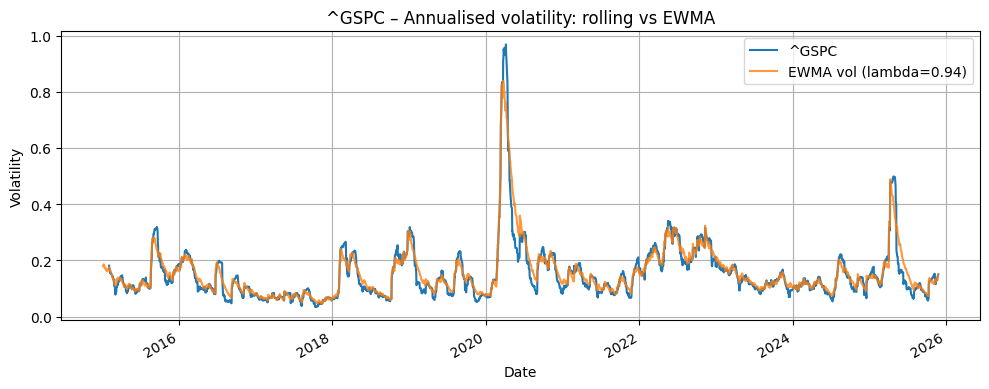

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))

ann_vol_21.plot(ax=ax, label=f"Rolling {window}-day vol")
ewma_ann_vol.plot(ax=ax, label=f"EWMA vol (lambda={lam})", alpha=0.8)

ax.set_title(f"{ticker} – Annualised volatility: rolling vs EWMA")
ax.set_ylabel("Volatility")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


EWMA treats recent returns as more informative than older ones, but it is still just a smoothing rule. The volatility plot suggests something stronger: periods of high volatility tend to follow each other, and calm periods do the same. In other words, volatility itself shows time-series behaviour. This is done in more advanced volatility models, such as GARCH, that can capture the volatility clustering more effectively.


### GARCH(1,1) Volatility

The idea here is to include the information that large shocks in returns tend to be followed by more volatile periods, and calm days tend to be followed by more calm days (volatility clustering) when calculating volatility.

In a simple GARCH(1,1) model, today’s variance $\sigma_t^2$ is built from three pieces: 
$$ \sigma_t^2 = \omega + \alpha\,\epsilon_{t-1}^2 + \beta\,\sigma_{t-1}^2 $$

- a constant baseline variance, represents a small, irreducible level of volatility that is present even when recent returns
have been quiet.
- a term proportional to yesterday’s squared return (the shock $\epsilon$ is the deviation of the latest return from the average return), 
- a term proportional to yesterday’s variance (the previous volatility level). 
  
The weights $ \omega, \alpha, \beta $ on these pieces are parameters that we estimate from the data.  

In this exercise, we assume that returns fluctuate around a constant mean and that the shocks $ \epsilon_t $ are normally
distributed with variance $ \sigma_t^2 $ for simplicity.  Given these assumptions, the GARCH(1,1) model uses maximum likelihood to estimate the parameters $ \mu, \omega, \alpha, \beta $ from the observed return series and produces a conditional volatility  $ \sigma_t $.

In [32]:
returns_garch = returns.squeeze()
returns_garch = pd.to_numeric(returns_garch, errors="coerce").dropna()

returns_garch_pct = returns_garch * 100

# Define a simple GARCH(1,1) with constant mean and normal errors
am = arch_model(
    returns_garch_pct,
    vol="Garch",
    p=1,
    q=1,
    mean="Constant",
    dist="normal",
)

garch_res = am.fit(disp="off")
print(garch_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3543.26
Distribution:                  Normal   AIC:                           7094.51
Method:            Maximum Likelihood   BIC:                           7118.17
                                        No. Observations:                 2740
Date:                Tue, Nov 25 2025   Df Residuals:                     2739
Time:                        17:38:17   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0827  1.431e-02      5.778  7.568e-09 [5.465e-0

In [33]:
# Conditional volatility (in percent, because we fed percent returns)
garch_daily_vol_pct = garch_res.conditional_volatility  # same index as returns
# Convert back to decimal and annualise
garch_daily_vol = garch_daily_vol_pct / 100.0
garch_ann_vol = garch_daily_vol * np.sqrt(252)

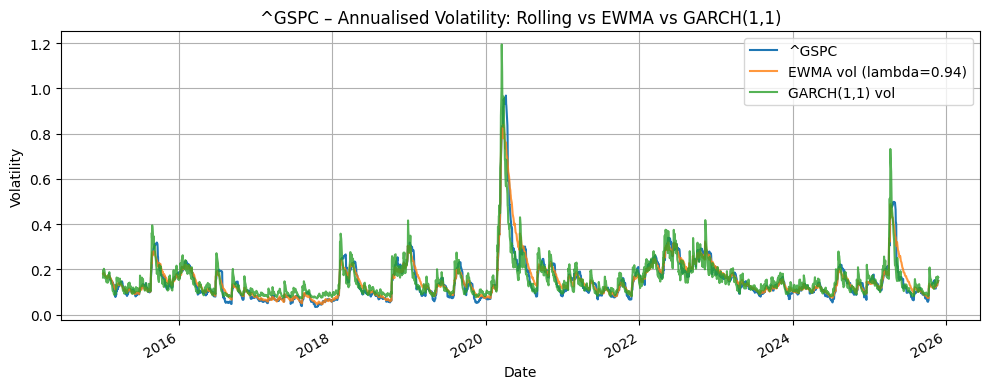

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))

ann_vol_21.plot(ax=ax, label=f"Rolling {window}-day vol")
ewma_ann_vol.plot(ax=ax, label=f"EWMA vol (lambda={lam})", alpha=0.8)
garch_ann_vol.plot(ax=ax, label="GARCH(1,1) vol", alpha=0.8)

ax.set_title(f"{ticker} – Annualised Volatility: Rolling vs EWMA vs GARCH(1,1)")
ax.set_ylabel("Volatility")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()